◈ Submit the python codes by May. 20 23:55
Breast Ultrasound Images Dataset(https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/code) 데이터셋에서 U-Net을 이용해 유방암 병변 분할하는 코드를 작성하시오.
코드 작성 내용
1.	U-Net 을 이용한 유방암 병변 분할
2.	모델 평가 (Dice Score 혹은 IoU 중 택 1)
3.	원본, Ground Truth 마스크, 모델 분할 결과 예시(1건 이상) 출력

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

In [3]:
# benign 파일 경로 지정
BASE_PATH = '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign'
IMAGES_PATH = os.path.join(BASE_PATH, 'Images')
MASKS_PATH = os.path.join(BASE_PATH, 'Masks')

# png 파일 모두 찾기
all_png_files = glob(os.path.join(BASE_PATH, "*.png"))

# 이미지 파일 리스트 생성 (_mask가 포함되지 않은 파일들)
benign_img_list = [f for f in all_png_files if '_mask' not in os.path.basename(f)]

# 마스크 파일 리스트 생성 (_mask가 포함된 파일들)
benign_mask_list = [f for f in all_png_files if '_mask' in os.path.basename(f)]

# 결과 출력 (선택 사항)
print("Image List: ", benign_img_list)
print("Mask List: ", benign_mask_list)

Image List:  ['/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (101).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (104).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (1).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (105).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (106).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (103).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (100).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (102).png', '/content/dr

In [4]:
# malignant 파일 경로 지정
BASE_PATH = '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/malignant'
IMAGES_PATH = os.path.join(BASE_PATH, 'Images')
MASKS_PATH = os.path.join(BASE_PATH, 'Masks')

# png 파일 모두 찾기
all_png_files = glob(os.path.join(BASE_PATH, "*.png"))

# 이미지 파일 리스트 생성 (_mask가 포함되지 않은 파일들)
malignant_img_list = [f for f in all_png_files if '_mask' not in os.path.basename(f)]

# 마스크 파일 리스트 생성 (_mask가 포함된 파일들)
malignant_mask_list = [f for f in all_png_files if '_mask' in os.path.basename(f)]

# 결과 출력 (선택 사항)
print("Image List: ", malignant_img_list)
print("Mask List: ", malignant_mask_list)

Image List:  ['/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/malignant/malignant (128).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/malignant/malignant (132).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/malignant/malignant (133).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/malignant/malignant (107).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/malignant/malignant (115).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/malignant/malignant (113).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/malignant/malignant (111).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_wi

In [5]:
# normal 파일 경로 지정
BASE_PATH = '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/normal'
IMAGES_PATH = os.path.join(BASE_PATH, 'Images')
MASKS_PATH = os.path.join(BASE_PATH, 'Masks')

# png 파일 모두 찾기
all_png_files = glob(os.path.join(BASE_PATH, "*.png"))

# 이미지 파일 리스트 생성 (_mask가 포함되지 않은 파일들)
normal_img_list = [f for f in all_png_files if '_mask' not in os.path.basename(f)]

# 마스크 파일 리스트 생성 (_mask가 포함된 파일들)
normal_mask_list = [f for f in all_png_files if '_mask' in os.path.basename(f)]

# 결과 출력 (선택 사항)
print("Image List: ", benign_img_list)
print("Mask List: ", normal_mask_list)

Image List:  ['/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (101).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (104).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (1).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (105).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (106).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (103).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (100).png', '/content/drive/MyDrive/대학/4학년 1학기/데이터 기계학습/과제/HW/HW3/Dataset_BUSI_with_GT/benign/benign (102).png', '/content/dr

In [6]:
# 이미지를 하나의 리스트로 병합
img_list = benign_img_list + malignant_img_list + normal_img_list

# 마스크를 하나의 리스트로 병합
mask_list = benign_mask_list + malignant_mask_list + normal_mask_list

In [ ]:
# 데이터셋 로드 함수
def load_data(img_list, mask_list, img_size=(128, 128)):
    images = []
    masks = []
    for img_path, mask_path in zip(img_list, mask_list):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)
        images.append(img)
        masks.append(mask)
    images = np.array(images).astype(np.float32) / 255.0
    masks = np.array(masks).astype(np.float32) / 255.0
    masks = np.expand_dims(masks, axis=-1) # (N, H, W, 1)
    return images, masks

# 데이터 로드
images, masks = load_data(img_list, mask_list)

In [ ]:
# 학습 및 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
# 모델 생성
model = unet_model()

# 모델 컴파일
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

Epoch 1/20
39/39 [==============================] - 37s 342ms/step - loss: 3.1034 - accuracy: 0.9192 - mean_io_u: 0.4613 - val_loss: 0.2843 - val_accuracy: 0.9215 - val_mean_io_u: 0.4618
Epoch 2/20
39/39 [==============================] - 8s 212ms/step - loss: 0.2787 - accuracy: 0.9204 - mean_io_u: 0.4613 - val_loss: 0.2847 - val_accuracy: 0.9215 - val_mean_io_u: 0.4618
Epoch 3/20
39/39 [==============================] - 8s 216ms/step - loss: 0.2667 - accuracy: 0.9204 - mean_io_u: 0.4613 - val_loss: 0.2525 - val_accuracy: 0.9215 - val_mean_io_u: 0.4618
Epoch 4/20
39/39 [==============================] - 8s 216ms/step - loss: 0.2377 - accuracy: 0.9204 - mean_io_u: 0.4613 - val_loss: 0.2188 - val_accuracy: 0.9215 - val_mean_io_u: 0.4618
Epoch 5/20
39/39 [==============================] - 8s 218ms/step - loss: 0.2309 - accuracy: 0.9204 - mean_io_u: 0.4613 - val_loss: 0.2225 - val_accuracy: 0.9215 - val_mean_io_u: 0.4618
Epoch 6/20
39/39 [==============================] - 9s 219ms/step - l

In [ ]:
# 모델 평가
loss, accuracy, mean_iou = model.evaluate(X_val, y_val, verbose=0)

In [ ]:
# 3. 원본, Ground Truth 마스크, 모델 분할 결과 예시(1건 이상) 출력
import matplotlib.pyplot as plt
import random

def plot_examples(X, y_true, y_pred, num_examples=1):
    indices = random.sample(range(len(X)), num_examples)
    plt.figure(figsize=(15, 5 * num_examples))

    for i, idx in enumerate(indices):
        img = X[idx]
        true_mask = y_true[idx].squeeze()
        pred_mask = y_pred[idx].squeeze()

        plt.subplot(num_examples, 3, 3 * i + 1)
        plt.title("Original Image")
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        plt.subplot(num_examples, 3, 3 * i + 2)
        plt.title("Ground Truth Mask")
        plt.imshow(true_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(num_examples, 3, 3 * i + 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


5/5 [==============================] - 1s 125ms/step


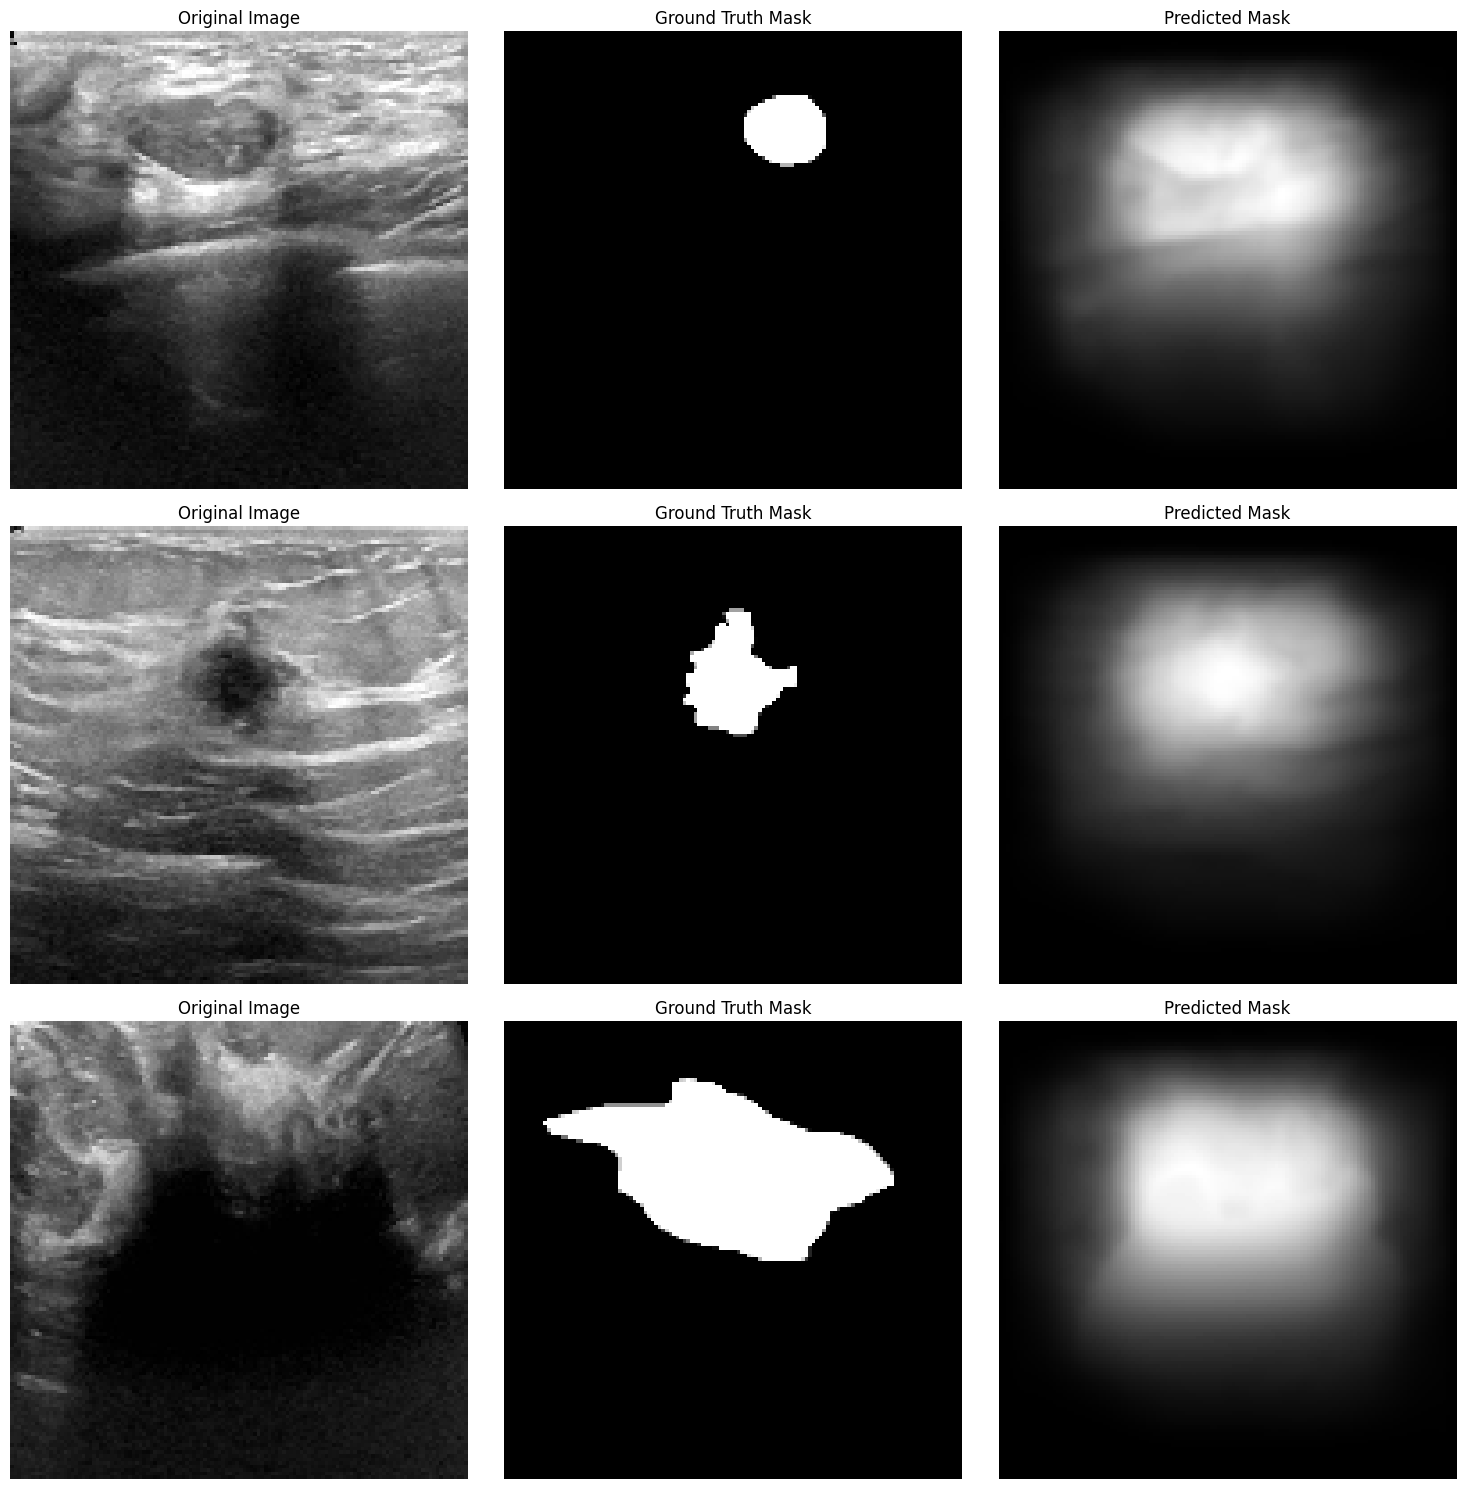

In [ ]:
# 모델 예측
y_pred = model.predict(X_val)

# 예시 출력
plot_examples(X_val, y_val, y_pred, num_examples=3)